In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
import numpy as np
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import math
import geopandas as gpd
from shapely.geometry import box
import os
from matplotlib.ticker import FuncFormatter

### Description:
______________
This script reads the skill score csv, and a shapefile path to create plots of BME scores across the CAMELS-SPAT basins.

### Inputs

In [2]:
# -------------------------------
# Load data
skill_scores_long = pd.read_csv('../camels-spat/03_results/nse/skill_scores/nse_skill_scores_rank_001.csv')
output_dir = '../camels-spat/03_results/nse_plots/'
plot_prefix = 'nse'

# -------------------------------
# Settings
period = 'validation'

# border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'
border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/data/boundaries_p_2021_v3.shp'

In [3]:
# Specify the benchmarks and metrics to calculate
map_plots = [
    # Flow
     "bm_mean_flow", 
    # "bm_median_flow",
    # "bm_monthly_mean_flow", 
    # "bm_monthly_median_flow",
      "bm_daily_mean_flow", 
    # "bm_daily_median_flow", 
    # "bm_eckhardt_baseflow",
    # # RRR
    # "bm_rainfall_runoff_ratio_to_all",
    # "bm_rainfall_runoff_ratio_to_annual",
    # "bm_rainfall_runoff_ratio_to_monthly",
    # "bm_rainfall_runoff_ratio_to_daily",
    # "bm_rainfall_runoff_ratio_to_timestep",
     "bm_monthly_rainfall_runoff_ratio_to_monthly",
    # "bm_monthly_rainfall_runoff_ratio_to_daily",
    # "bm_monthly_rainfall_runoff_ratio_to_timestep",
    # "bm_scaled_precipitation_benchmark",
    # # Precipitation Anomaly
     "bm_annual_scaled_daily_mean_flow",
    # "bm_monthly_scaled_daily_mean_flow",
    # # Parsimonious Models
    # "bm_adjusted_precipitation_benchmark",
     "bm_adjusted_smoothed_precipitation_benchmark",
    # "bm_baseflow_with_event_peaks",
    # "bm_api_scaled_flow",

    # # Summary 
    # 'highest',
     'lowest'
      ]

difference_plots= [
    # Streamflow benchmarks
    "bm_mean_flow",
    'difference'
]

# Specify the benchmarks and metrics to calculate
cdf_plots = [
    # Flow
    "bm_mean_flow", "bm_median_flow",
    "bm_monthly_mean_flow", "bm_monthly_median_flow",
    "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow",
    # RRR
    "bm_rainfall_runoff_ratio_to_all",
    "bm_rainfall_runoff_ratio_to_annual",
    "bm_rainfall_runoff_ratio_to_monthly",
    "bm_rainfall_runoff_ratio_to_daily",
    "bm_rainfall_runoff_ratio_to_timestep",
    "bm_monthly_rainfall_runoff_ratio_to_monthly",
    "bm_monthly_rainfall_runoff_ratio_to_daily",
    "bm_monthly_rainfall_runoff_ratio_to_timestep",
    "bm_scaled_precipitation_benchmark",
    # Precipitation and streamflow
    "bm_annual_scaled_daily_mean_flow",
    "bm_monthly_scaled_daily_mean_flow",
    "bm_eckhardt_baseflow",
    # Parsimonious Models
    "bm_adjusted_precipitation_benchmark",
    "bm_adjusted_smoothed_precipitation_benchmark",

    # Summary 
    'highest',
    'lowest'
     ]

### Pre-Processing

In [4]:
# Filter by period
df_period = skill_scores_long[skill_scores_long['period'] == period]

# Function to get value + corresponding benchmark
def get_extreme(df, agg_func='max'):
    if agg_func == 'max':
        idx = df['skill_score'].idxmax()
    else:
        idx = df['skill_score'].idxmin()
    return pd.Series({
        'value': df.loc[idx, 'skill_score'],
        'benchmark': df.loc[idx, 'benchmark']
    })

# Compute highest and lowest per catchment
catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(
    lambda x: pd.concat([
        get_extreme(x, 'max').rename(lambda k: f'highest_{k}'),
        get_extreme(x, 'min').rename(lambda k: f'lowest_{k}')
    ])
).reset_index()

# Merge lat/lon
latlon = df_period[['catchment','latitude','longitude']].drop_duplicates()
catchment_stats = catchment_extremes.merge(latlon, on='catchment', how='left')

/var/folders/vb/mywh1k096gd_zrr2cr3d6rs40000gn/T/ipykernel_69639/873659307.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(


In [5]:
# --- Load borders shapefile once
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    
    # Reproject to EPSG:4326 if needed
    if gdf_borders.crs != "EPSG:4326":
        gdf_borders = gdf_borders.to_crs("EPSG:4326")
    
    map_color = '0.65'

### Spatial Plots

In [6]:
def format_benchmark_name(benchmark_name):
    """Format benchmark names for display with category prefix"""
    categories = {
        'Streamflow': [
            "bm_mean_flow", "bm_median_flow",
            "bm_monthly_mean_flow", "bm_monthly_median_flow",
            "bm_daily_mean_flow", "bm_daily_median_flow"
        ],
        'P&S': [
            "bm_rainfall_runoff_ratio_to_all",
            "bm_rainfall_runoff_ratio_to_annual",
            "bm_rainfall_runoff_ratio_to_monthly",
            "bm_rainfall_runoff_ratio_to_daily",
            "bm_rainfall_runoff_ratio_to_timestep",
            "bm_monthly_rainfall_runoff_ratio_to_monthly",
            "bm_monthly_rainfall_runoff_ratio_to_daily",
            "bm_monthly_rainfall_runoff_ratio_to_timestep",
            "bm_scaled_precipitation_benchmark",
            "bm_annual_scaled_daily_mean_flow",
            "bm_monthly_scaled_daily_mean_flow",
        ],
        'Models': [
            "bm_eckhardt_baseflow"
            "bm_adjusted_precipitation_benchmark",
            "bm_adjusted_smoothed_precipitation_benchmark",
        ],
        'Combined': [
            "highest",
            "lowest",
        ],
    }
    
    # Find category for this benchmark
    category = None
    for cat, benchmarks in categories.items():
        if benchmark_name in benchmarks:
            category = cat
            break
    
    # Format the benchmark name
    name = benchmark_name[3:] if benchmark_name.startswith('bm_') else benchmark_name
    name = name.replace('_', ' ').title()
    
    # Add category prefix
    if category:
        return f"{category}: {name}"
    else:
        return name

In [7]:
# Prepare data for plotting
plot_dfs = {}

for benchmark in map_plots:
    if benchmark == 'highest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']]\
            .rename(columns={'highest_value':'skill_score'})
    
    elif benchmark == 'lowest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']]\
            .rename(columns={'lowest_value':'skill_score'})
    
    elif benchmark == 'difference':
        # Extract mean_flow rows
        df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
            'catchment', 'latitude', 'longitude', 'skill_score'
        ]].rename(columns={'skill_score': 'mean_flow_score'})
        
        # Extract lowest values from catchment_stats
        df_low = catchment_stats[['catchment', 'lowest_value']]
        
        # Merge
        df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')
        
        # Compute difference
        df_diff['skill_score'] = df_diff['mean_flow_score'] - df_diff['lowest_value']
        
        # Keep only necessary columns for plotting
        plot_dfs[benchmark] = df_diff[['catchment', 'latitude', 'longitude', 'skill_score']]
    
    else:
        plot_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][
            ['catchment','latitude','longitude','skill_score']
        ]


Plotting bm_mean_flow
Plotting bm_daily_mean_flow
Plotting bm_monthly_rainfall_runoff_ratio_to_monthly
Plotting bm_annual_scaled_daily_mean_flow
Plotting bm_adjusted_smoothed_precipitation_benchmark
Plotting lowest


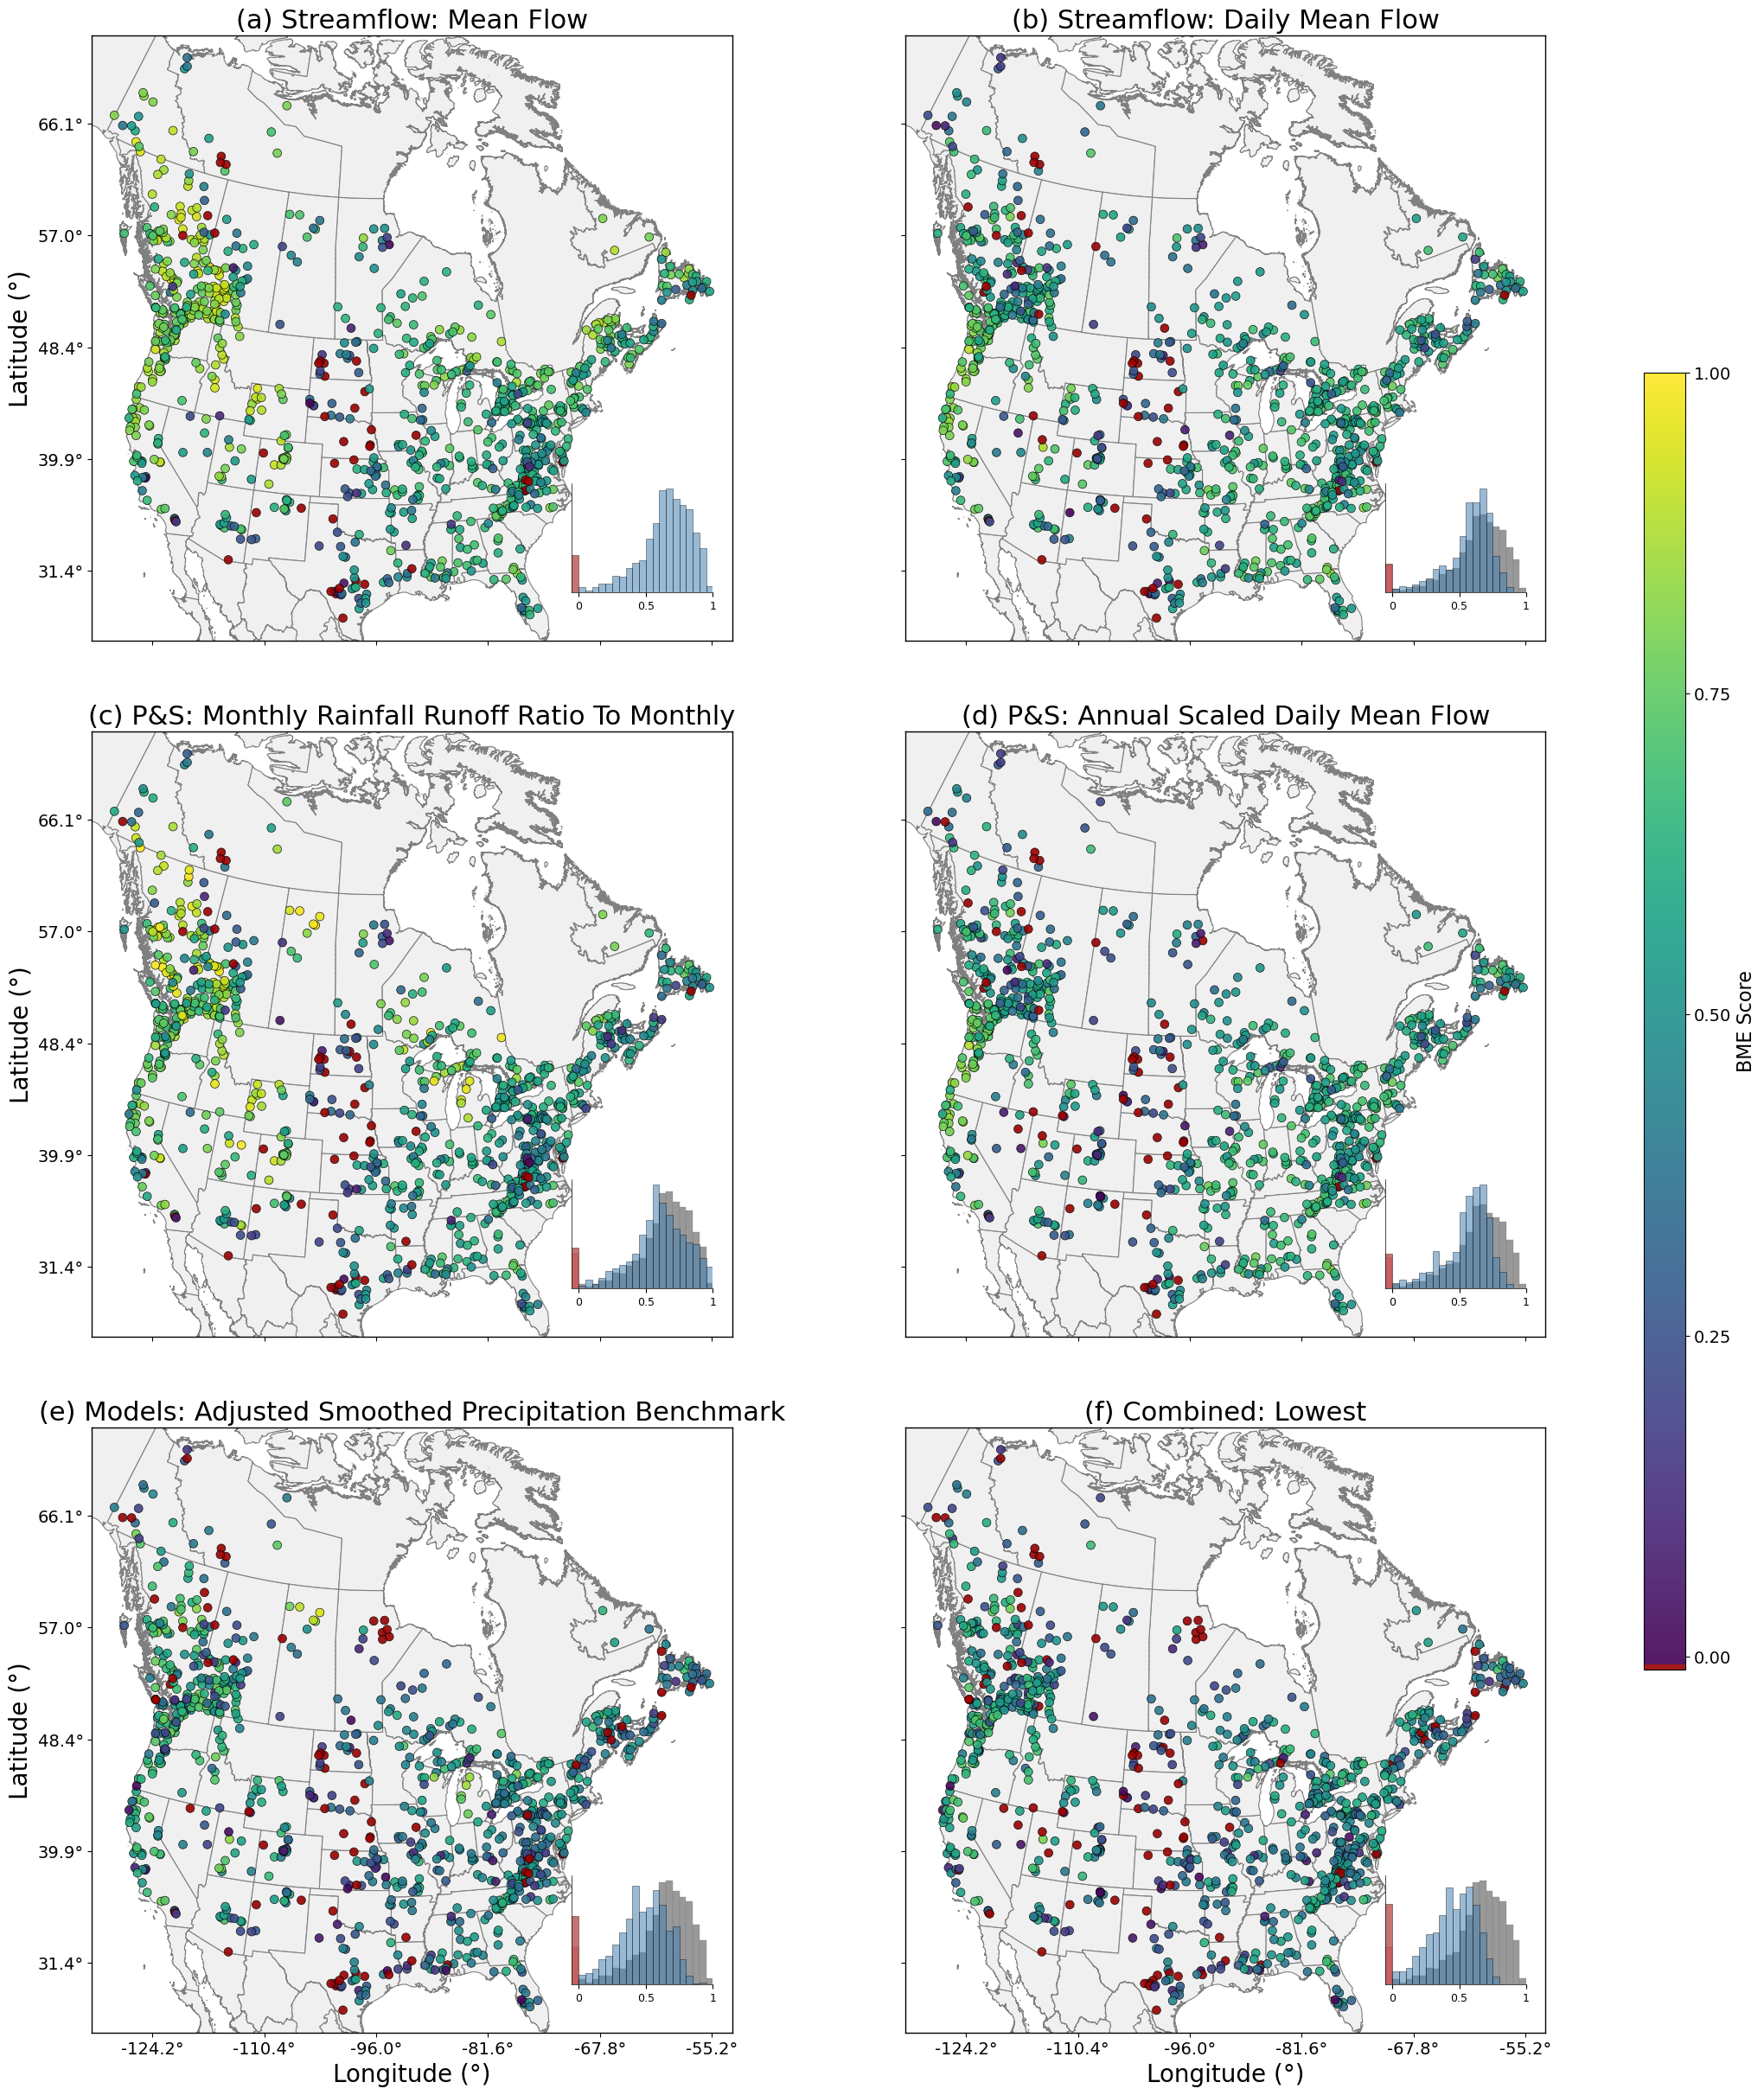

In [8]:
# --- Helper function to add histogram
def add_histogram(ax, position, data, n_bins=20, color='gray', alpha=0.7, background_data=None):
    """
    Add a small histogram inset to a subplot.
    
    Parameters:
    -----------
    ax : matplotlib axis
        The axis to add the histogram to
    position : list
        [left, bottom, width, height] in axis coordinates
    data : array-like
        The data to plot
    n_bins : int
        Number of histogram bins for positive values
    color : str
        Color of histogram bars for positive values
    alpha : float
        Transparency of histogram bars
    background_data : array-like, optional
        Background data to plot in light grey behind the main histogram
    """
    # Create inset axis
    inset_ax = ax.inset_axes(position)
    
    # Create custom bins: one wide bin for negative values [-100, 0), then regular bins from [0, 1]
    negative_bin = [-100, 0]
    positive_bins = np.linspace(0, 1, n_bins + 1)
    bins = np.concatenate([negative_bin, positive_bins[1:]])  # Avoid duplicate 0
    
    # Plot background histogram first if provided
    if background_data is not None:
        counts_bg, edges_bg, patches_bg = inset_ax.hist(
            background_data, bins=bins, color='grey', alpha=0.8, 
            edgecolor='grey', linewidth=0.3
        )
        # Color the first bar (negative values) red for background
        if len(patches_bg) > 0:
            patches_bg[0].set_facecolor('#ffcccc')  # Light red
    
    # Plot main histogram with custom bins
    counts, edges, patches = inset_ax.hist(data, bins=bins, color=color, alpha=alpha, 
                                            edgecolor='black', linewidth=0.5)
    
    # Color the first bar (negative values) red to match the map
    if len(patches) > 0:
        patches[0].set_facecolor('#990000')  # Dark red to match neg_color
    
    # Set x-axis limits to show from -0.05 to 1
    inset_ax.set_xlim(-0.05, 1)
    
    # Add x-axis labels
    inset_ax.set_xticks([0, 0.5, 1])
    inset_ax.set_xticklabels(['0', '0.5', '1'], fontsize=9)
    
    # Remove y-axis ticks
    inset_ax.set_yticks([])
    inset_ax.tick_params(left=False, bottom=True, labelsize=9)
    
    # Remove top and right spines
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)
    
    # Style the remaining spines
    inset_ax.spines['left'].set_linewidth(0.5)
    inset_ax.spines['bottom'].set_linewidth(0.5)
    
    # Set background
    inset_ax.patch.set_alpha(0.8)
    inset_ax.patch.set_facecolor('white')
    
    return inset_ax

# --- Colormap setup
viridis = plt.cm.viridis
cmap_array = viridis(np.linspace(0, 1, 256))
neg_color = np.array([[0.6, 0, 0, 1]])  # dark red RGBA
cmap = ListedColormap(np.vstack([neg_color, cmap_array]))

# Reproject borders to North America Albers Equal Area
target_crs = "ESRI:102008"
if gdf_borders.crs != target_crs:
    gdf_borders = gdf_borders.to_crs(target_crs)

# Grid layout
n_cols = 2
n_plots = len(plot_dfs)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12 * n_cols, 10 * n_rows)
)
axes = axes.flatten() if n_plots > 1 else [axes]

# Subplot labels
subplot_labels = [chr(97 + i) for i in range(n_plots)]  # a, b, c, ...

# Get mean flow data for background (first benchmark)
mean_flow_data = None
if len(plot_dfs) > 0:
    mean_flow_data = list(plot_dfs.values())[0]['skill_score']

for idx, (ax, (benchmark, df_plot)) in enumerate(zip(axes, plot_dfs.items())):
    print(f'Plotting {benchmark}')
    
    # Calculate row and column indices
    row = idx // n_cols
    col = idx % n_cols
    
    # --- Format title with category prefix and subplot label
    title = f"({subplot_labels[idx]}) {format_benchmark_name(benchmark)}"
    
    # --- Convert point data to GeoDataFrame and reproject
    gdf_points = gpd.GeoDataFrame(
        df_plot,
        geometry=gpd.points_from_xy(df_plot['longitude'], df_plot['latitude']),
        crs="EPSG:4326"
    ).to_crs(target_crs)
    
    # Extract projected coordinates
    gdf_points['x_proj'] = gdf_points.geometry.x
    gdf_points['y_proj'] = gdf_points.geometry.y
    
    # --- Trim extent with buffer (in projected coordinates - meters)
    buffer = 200000  # 200 km buffer
    x_min, x_max = gdf_points['x_proj'].min() - buffer, gdf_points['x_proj'].max() + buffer
    y_min, y_max = gdf_points['y_proj'].min() - buffer, gdf_points['y_proj'].max() + buffer
    
    # --- Filter borders shapefile to bbox
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= x_max) &
        (gdf_borders.geometry.bounds.maxx >= x_min) &
        (gdf_borders.geometry.bounds.miny <= y_max) &
        (gdf_borders.geometry.bounds.maxy >= y_min)
    ]
    
    # --- Plot the borders
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Set extent
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # --- Scatter points
    colors = np.where(gdf_points['skill_score'] < 0, -0.01, gdf_points['skill_score'])
    sc = ax.scatter(
        gdf_points['x_proj'], gdf_points['y_proj'],
        c=colors,
        cmap=cmap,
        s=50,
        edgecolor='k',
        linewidths=0.5,
        alpha=0.9,
        norm=Normalize(vmin=-0.01, vmax=1),
        zorder=3,
        rasterized=False
    )
    
    # --- Create formatter functions to convert projected coords to lat/lon
    from shapely.geometry import Point
    
    def x_formatter(x, pos):
        """Convert x (projected) to longitude"""
        y_center = (y_min + y_max) / 2
        point_proj = gpd.GeoSeries([Point(x, y_center)], crs=target_crs)
        point_latlon = point_proj.to_crs("EPSG:4326")
        return f'{point_latlon.x.values[0]:.1f}°'
    
    def y_formatter(y, pos):
        """Convert y (projected) to latitude"""
        x_center = (x_min + x_max) / 2
        point_proj = gpd.GeoSeries([Point(x_center, y)], crs=target_crs)
        point_latlon = point_proj.to_crs("EPSG:4326")
        return f'{point_latlon.y.values[0]:.1f}°'
    
    # Apply formatters
    ax.xaxis.set_major_formatter(FuncFormatter(x_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))
    
    # --- Add histogram inset (moved higher and further right)
    hist_position = [0.75, 0.08, 0.22, 0.18]  # Moved from [0.72, 0.03, 0.25, 0.18]
    background = mean_flow_data if idx > 0 else None
    add_histogram(ax, hist_position, gdf_points['skill_score'], 
                  n_bins=20, color='steelblue', alpha=0.55,
                  background_data=background)
    
    # --- Format axes
    ax.set_title(title, fontsize=22)  # Increased from 20
    
    # Only show x-axis label on bottom row
    if row == n_rows - 1:
        ax.set_xlabel('Longitude (°)', fontsize=20)  # Increased from 18
        ax.tick_params(axis='x', labelsize=14)  # Changed from 26 to normal
    else:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False, labelsize=14)
    
    # Only show y-axis label on first column
    if col == 0:
        ax.set_ylabel('Latitude (°)', fontsize=20)  # Increased from 18
        ax.tick_params(axis='y', labelsize=14)  # Keep at 14 (normal)
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False, labelsize=14)
    
    ax.grid(False)
    
    # Box around plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')

# Remove any empty axes
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Adjust layout - reduced spacing
plt.subplots_adjust(hspace=0.15, wspace=0.08, right=0.88)  # Reduced from hspace=0.3, wspace=0.1

# Colorbar
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('BME Score', fontsize=16)  # Increased from 14
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=14)  # Increased colorbar tick labels

# --- Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.pdf', dpi=300)
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.png', dpi=300)
plt.show()

### Difference Between NSE and Lowest Benchmark

In [9]:
# Extract mean_flow rows
df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
    'catchment', 'latitude', 'longitude', 'skill_score'
]].rename(columns={'skill_score': 'mean_flow_score'})

# Extract lowest values from catchment_stats
df_low = catchment_stats[['catchment', 'lowest_value']]

# Merge
df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')

# Compute difference
df_diff['skill_diff'] = df_diff['mean_flow_score'] - df_diff['lowest_value']

### CDF

In [10]:
# Prepare data for plotting
cdf_dfs = {}  # initialize dictionary
for benchmark in cdf_plots:
    if benchmark == 'highest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']].rename(columns={'highest_value':'skill_score'})
    elif benchmark == 'lowest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']].rename(columns={'lowest_value':'skill_score'})
    else:
        cdf_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][['catchment','latitude','longitude','skill_score']]


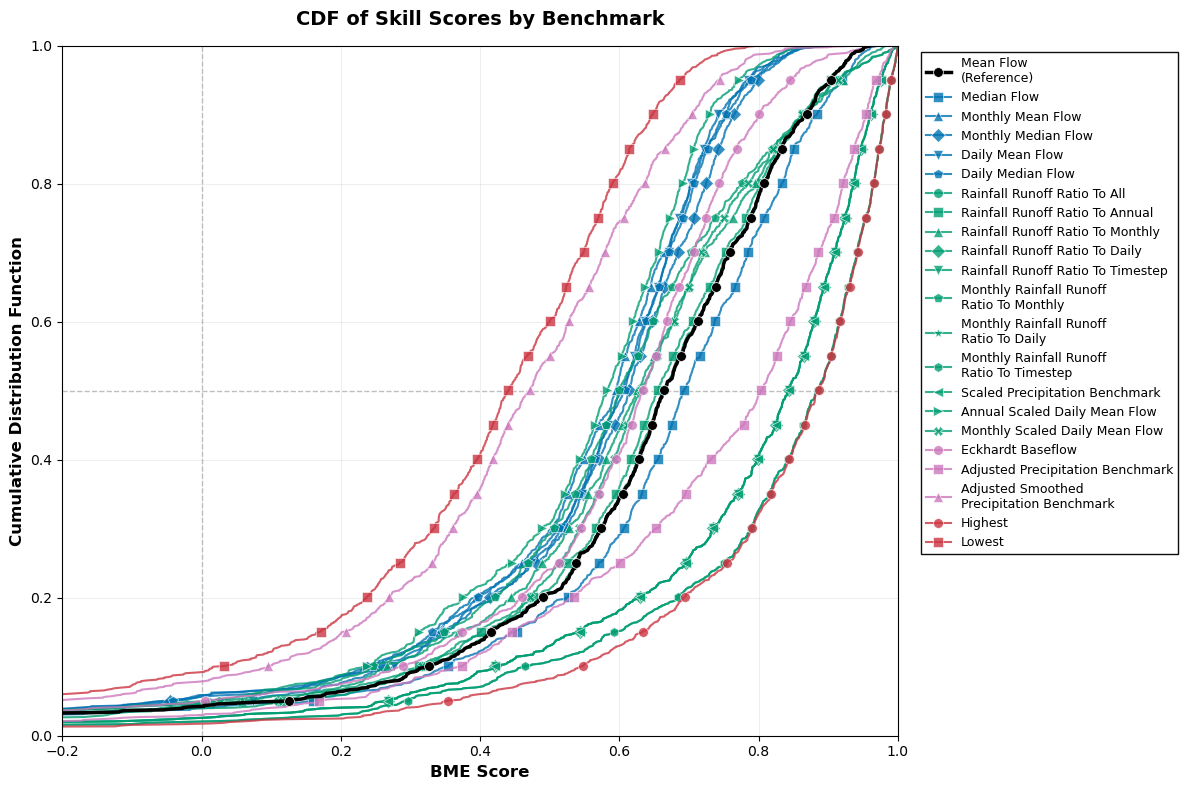

In [11]:
# Define categories
categories = {
    'Streamflow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow"
    ],
    'P&S': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
        "bm_annual_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
    ],
    'Models': [
        "bm_eckhardt_baseflow",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
    ],
    'Combined': ['highest', 'lowest']
}

# Improved color palette - more distinct and professional
# Using colorblind-friendly palette with better contrast
colors = {
    'Streamflow': '#0173B2',              # Deep blue
    'P&S': '#029E73',   # Teal/green
    'Models': '#CC78BC',            # Purple/magenta
    'Combined': '#CA3542'           # Red
}

# Define a diverse set of markers
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '<', '>', 'X', 'P']

# Helper function to clean benchmark names WITHOUT category prefix
def clean_label(name, category, max_length=35):
    """Clean benchmark name with line breaks for long names"""
    # Remove 'bm_' prefix
    name = name.replace("bm_", "")
    # Replace underscores with spaces
    name = name.replace("_", " ")
    # Capitalize each word
    name = name.title()
    
    # Add line break if too long
    if len(name) > max_length:
        words = name.split()
        mid_point = len(words) // 2
        line1 = " ".join(words[:mid_point])
        line2 = " ".join(words[mid_point:])
        name = f"{line1}\n{line2}"
    
    return name


# Create figure with better styling
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each category
for cat, benchmarks in categories.items():
    for i, benchmark in enumerate(benchmarks):
        if benchmark in cdf_dfs:
            scores = cdf_dfs[benchmark]['skill_score'].dropna().sort_values()
            cdf = np.arange(1, len(scores)+1) / len(scores)
            
            # Cycle markers
            marker = markers[i % len(markers)]
            
            # Highlight bm_mean_flow as reference benchmark
            if benchmark == 'bm_mean_flow':
                lw = 2.5
                alpha = 1.0
                linestyle = '-'
                zorder = 10
                color = 'black'
                markersize = 7  # Increased from 6
                label = "Mean Flow\n(Reference)"
            else:
                lw = 1.5
                alpha = 0.8
                linestyle = '-'
                zorder = 1
                color = colors[cat]
                markersize = 7  # Increased from 5
                label = clean_label(benchmark, cat)
            
            ax.plot(
                scores, cdf,
                label=label,
                color=color,
                marker=marker,
                markevery=max(1, len(scores)//20),
                alpha=alpha,
                linewidth=lw,
                linestyle=linestyle,
                zorder=zorder,
                markersize=markersize,
                markeredgewidth=0.5,
                markeredgecolor='white'
            )

# Styling improvements
ax.set_xlabel('BME Score', fontsize=12, weight='bold')
ax.set_ylabel('Cumulative Distribution Function', fontsize=12, weight='bold')
ax.set_title('CDF of Skill Scores by Benchmark', fontsize=14, weight='bold', pad=15)
ax.set_xlim(-0.2, 1)
ax.set_ylim(0, 1)

# Add reference lines
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# Grid styling
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Legend with category grouping
# Create custom legend with category headers
handles, labels = ax.get_legend_handles_labels()

# Sort by category - use actual category names from the dict
category_order = ['Streamflow', 'P&S', 'Models', 'Combined']
sorted_handles = []
sorted_labels = []

for cat in category_order:
    # Find all benchmarks in this category
    cat_indices = []
    for i, label in enumerate(labels):
        # For reference benchmark
        if "Reference" in label and cat == "Streamflow":
            cat_indices.append(i)
        # More robust check: see if any benchmark from this category matches
        elif any(clean_label(b, cat) == label for b in categories.get(cat, [])):
            cat_indices.append(i)
    
    if cat_indices:
        # Add benchmarks from this category
        for idx in cat_indices:
            sorted_handles.append(handles[idx])
            sorted_labels.append(labels[idx])

# Create legend outside plot area with better formatting
legend = ax.legend(
    sorted_handles, sorted_labels,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    frameon=True,
    framealpha=0.95,
    edgecolor='black',
    fancybox=False,
    shadow=False,
    ncol=1
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout()

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Statistics

In [12]:
# 1. Per-benchmark stats
stats_df = pd.DataFrame(columns=['benchmark','mean','median','std','iqr','min','max'])
for benchmark, df in cdf_dfs.items():
    scores = df['skill_score'].dropna()
    stats_df = pd.concat([
        stats_df,
        pd.DataFrame([{
            'benchmark': benchmark,
            'mean': scores.mean(),
            'median': scores.median(),
            'std': scores.std(),
            'iqr': scores.quantile(0.75) - scores.quantile(0.25),
            'min': scores.min(),
            'max': scores.max()
        }])
    ], ignore_index=True)

# 2. Per-group stats
group_stats = pd.DataFrame(columns=['group','mean','median','std','iqr','min','max'])
for group, benchmarks in categories.items():
    # collect all scores in this group
    all_scores = pd.concat([cdf_dfs[b]['skill_score'].dropna() for b in benchmarks if b in cdf_dfs])
    if len(all_scores) > 0:
        group_stats = pd.concat([
            group_stats,
            pd.DataFrame([{
                'group': group,
                'mean': all_scores.mean(),
                'median': all_scores.median(),
                'std': all_scores.std(),
                'iqr': all_scores.quantile(0.75) - all_scores.quantile(0.25),
                'min': all_scores.min(),
                'max': all_scores.max()
            }])
        ], ignore_index=True)



/var/folders/vb/mywh1k096gd_zrr2cr3d6rs40000gn/T/ipykernel_69639/3254197652.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([
/var/folders/vb/mywh1k096gd_zrr2cr3d6rs40000gn/T/ipykernel_69639/3254197652.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_stats = pd.concat([


In [13]:
# Ensure highest and lowest exist
if 'highest' in plot_dfs and 'lowest' in plot_dfs:
    # Get scores
    high_scores = plot_dfs['highest']['skill_score'].dropna().sort_values()
    low_scores = plot_dfs['lowest']['skill_score'].dropna().sort_values()
    
    # Compute CDFs
    high_cdf = np.arange(1, len(high_scores)+1) / len(high_scores)
    low_cdf = np.arange(1, len(low_scores)+1) / len(low_scores)
    
    # Find CDF value at skill_score = 0
    # Use searchsorted to find the index where score >= 0
    idx_high = np.searchsorted(high_scores, 0)
    idx_low = np.searchsorted(low_scores, 0)
    
    # Probability that score <= 0
    prob_high = high_cdf[idx_high] if idx_high < len(high_cdf) else 1.0
    prob_low = low_cdf[idx_low] if idx_low < len(low_cdf) else 1.0
    
    diff_prob = prob_high - prob_low
    
    print(f"Probability (skill <= 0) for 'highest': {prob_high:.2f}")
    print(f"Probability (skill <= 0) for 'lowest': {prob_low:.2f}")
    print(f"Difference in probability: {diff_prob:.2f}")
else:
    print("Highest or lowest benchmark missing in plot_dfs")

Highest or lowest benchmark missing in plot_dfs


In [14]:

# Filter to remove NaN skill scores
df_valid = df_period.dropna(subset=['skill_score']).copy()

# Find the benchmark with the minimum skill score per catchment
lowest_per_catchment = df_valid.loc[df_valid.groupby('catchment')['skill_score'].idxmin()]

# Count how many times each benchmark is the lowest
lowest_counts = lowest_per_catchment['benchmark'].value_counts().sort_values(ascending=False)

# Convert to DataFrame
lowest_counts_df = lowest_counts.reset_index()
lowest_counts_df.columns = ['benchmark', 'count']

# Apply formatting: remove 'bm_' prefix, replace '_' with space, capitalize words
lowest_counts_df['benchmark'] = (
    lowest_counts_df['benchmark']
    .str.replace(r'^bm_', '', regex=True)  # remove 'bm_' prefix
    .str.replace('_', ' ')                  # replace underscores with spaces
    .str.title()                            # capitalize first letter of each word
)

In [15]:
# Filter to remove NaN skill scores
df_valid = df_period.dropna(subset=['skill_score']).copy()

# Find the benchmark with the minimum skill score per catchment
lowest_per_catchment = df_valid.loc[df_valid.groupby('catchment')['skill_score'].idxmin()]

# Count how many times each benchmark is the lowest
lowest_counts = lowest_per_catchment['benchmark'].value_counts().sort_values(ascending=False)

# Convert to DataFrame
lowest_counts_df = lowest_counts.reset_index()
lowest_counts_df.columns = ['benchmark', 'count']

# Count negative skill scores for each benchmark
negative_counts = (
    df_valid[df_valid['skill_score'] < 0]
    .groupby('benchmark')
    .size()
    .reset_index(name='negative_count')
)

# Merge the negative counts with the lowest counts
lowest_counts_df = lowest_counts_df.merge(
    negative_counts,
    on='benchmark',
    how='left'
)

# Fill NaN with 0 (benchmarks that never had negative skill scores)
lowest_counts_df['negative_count'] = lowest_counts_df['negative_count'].fillna(0).astype(int)

# Apply formatting: remove 'bm_' prefix, replace '_' with space, capitalize words
lowest_counts_df['benchmark'] = (
    lowest_counts_df['benchmark']
    .str.replace(r'^bm_', '', regex=True)  # remove 'bm_' prefix
    .str.replace('_', ' ')                  # replace underscores with spaces
    .str.title()                            # capitalize first letter of each word
)

In [16]:
lowest_counts_df['% most challenging'] = lowest_counts_df['count'] / lowest_counts_df['count'].sum()

In [17]:
lowest_counts_df['count'].sum()

np.int64(960)

In [18]:
lowest_counts_df

,benchmark,count,negative_count,% most challenging
0,Adjusted Smoothed Precipitation Benchmark,626,75,0.652083
1,Annual Scaled Daily Mean Flow,156,46,0.162500
2,Monthly Rainfall Runoff Ratio To Monthly,44,47,0.045833
3,Monthly Mean Flow,26,54,0.027083
4,Adjusted Precipitation Benchmark,22,28,0.022917
5,Rainfall Runoff Ratio To Monthly,16,44,0.016667
6,Monthly Scaled Daily Mean Flow,12,38,0.012500
7,Daily Mean Flow,11,41,0.011458
8,Monthly Median Flow,11,56,0.011458
9,Eckhardt Baseflow,10,48,0.010417
